# Simulate (winning) model
---

Plan is to validate the winning model (PIECE) by simulating with MLE parameters and running behavioral analysis on outputs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logsumexp
from scipy.stats import norm
import scipy as sp
import random
from statsmodels.formula.api import ols
from src.functions import * 

# Set some defaults
plt.rc("axes.spines", top=False, right=False)

sns.set_theme(context="paper", font_scale=1.2)
sns.set_style("ticks")

# Import python library/function for function optimization
import scipy.optimize

%config InlineBackend.figure_format = "retina"

## The Plan
---
1) Load MLEs for PIECE model
2) Simulate 16 subjects' worth of data
3) Run some behavioral analyses, as if this were real data. 

In [2]:
# Read in vmr data
df = pd.read_csv("../results/vmr_all.csv")

# Read in csv with MLEs from all models
# Need a function to convert string back to numpy array
def converter(input_str):
    return np.fromstring(input_str[1:-1], sep=' ')

fits = pd.read_csv("../results/params_mle_reducedmodels.csv", converters={"theta":converter})
fits.head()

,subj_num,model,theta,loglik,bic,delta_bic
0,1,pea,"[9.34023228, 0.36206566, 1.29827665]",-2650.946357,5323.229696,-209.503440
1,1,premo,"[0.843862233, 16.7663819, 0.01, 25.0, 1.0, 1.0...",-2745.029585,5532.733135,0.000000
2,1,rem,"[14.2432723, 3.81197959, 9.99980445, 1.29836274]",-2650.973430,5330.396170,-202.336966
3,1,piece,"[5.95716432, 0.01, 1.01037002]",-2526.204156,5073.745295,-458.987840
4,2,pea,"[3.76251428, 0.49892211, 0.89640008]",-2854.631264,5730.599509,-186.281992


In [3]:
# Pick out PIECE params
params_piece = fits.groupby("model")["theta"].apply(np.stack)["piece"]
params_piece

array([[ 5.95716432,  0.01      ,  1.01037002],
       [ 5.99807037,  0.01      ,  0.719489  ],
       [ 3.60770892,  1.40326387,  1.83836669],
       [ 4.52852658,  0.05377581,  0.18342366],
       [ 4.95486831,  0.39340687,  0.50659042],
       [ 5.91331328,  0.01      ,  0.4119871 ],
       [ 5.79672856,  0.55380508,  0.49126064],
       [ 5.26833472,  0.05465648,  1.42696761],
       [ 5.71430909,  0.01549951,  1.77810237],
       [ 5.65714949,  0.05683875,  0.70467085],
       [ 6.10659727,  0.06063287,  1.34433889],
       [ 4.93053322,  0.01      ,  0.33431048],
       [ 4.19651317,  0.01      ,  1.14465272],
       [ 6.33743174,  0.01      , -0.67215321],
       [ 5.68379772,  0.01      , -0.00917741],
       [ 4.07872951,  1.02456771,  0.14417792]])

In [4]:
# Pull out experimental parameters (same for all 16 subjects)
rotation = df.loc[df["SN"] == 1, "rotation"].values
vis_fb = df.loc[df["SN"] == 1, "fbi"].values
idx_pert = df.loc[df["SN"] == 1, "perturbation"].values
num_trials = len(np.unique(df["TN"]))

subj_id = []
trial_num = []
hand_angle = []
n_subj = len(np.unique(df["SN"]))
beta_ege = np.zeros(n_subj)
beta_ige = np.zeros(n_subj)
df_sim = pd.DataFrame()

# Simulate behavior with model
for i in range(n_subj):
    print(i)
    
    # Sample from range of reasonable values
    motor_sd = df.loc[df["SN"] == i + 1, "motor_sd"].iloc[0]
    
    # Generate parameter values for each model through random sampling
    simparams = params_piece[i, :]
    
    # Simulate with best-fit parameters
    # PIECE model
    _, xhat = piece(
        simparams[0], 
        simparams[1], 
        simparams[2], 
        motor_sd, len(rotation), 
        vis_fb, 
        rotation,
        fit=False
    )
    
    # Create data frame; trim vars to keep only adaptation rows
    n_adapt = idx_pert.sum()
    subj_id = np.ones(n_adapt) * (i + 1)
    ege = rotation[idx_pert]
    hand_angle = xhat[idx_pert]
    adapt = np.zeros(n_adapt)
    pert_indices = np.flatnonzero(idx_pert)
    adapt = xhat[pert_indices + 1] - xhat[pert_indices - 1]

    subj = pd.DataFrame({
        "subj_id":subj_id, "ege":ege, "ige":hand_angle, 
        "adapt":adapt})
    
    # Fit the regression models
    model_vmr = ols("adapt ~ ege + ige - 1", subj).fit()
    beta_ege[i] = model_vmr._results.params[0]
    beta_ige[i] = model_vmr._results.params[1]

    df_sim = pd.concat([df_sim, subj], ignore_index=True)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


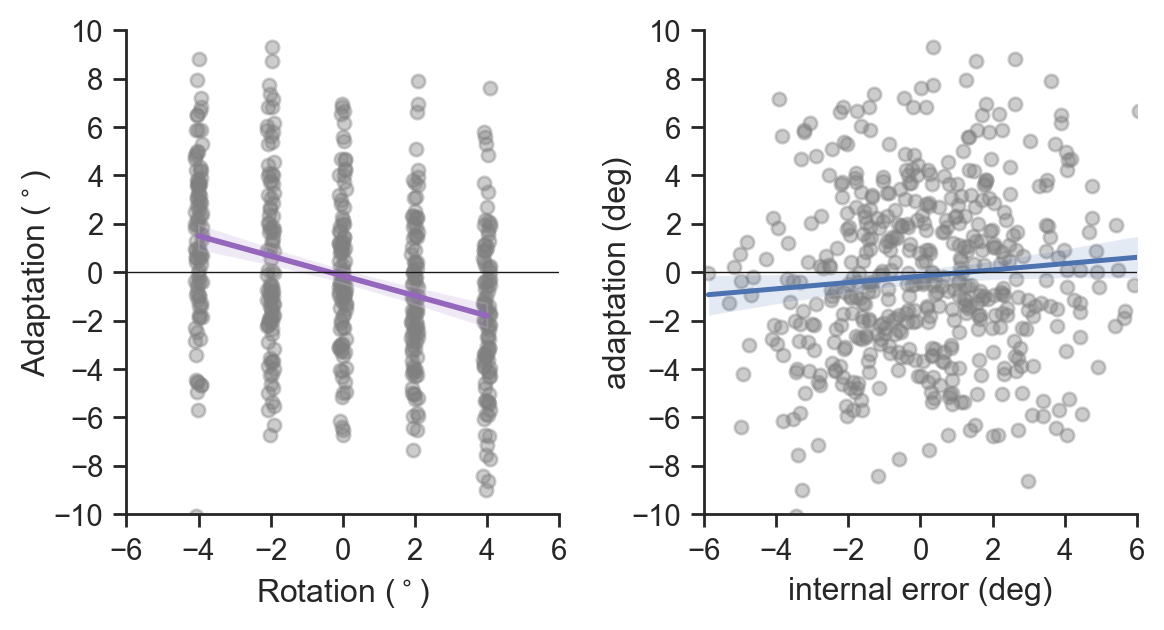

In [10]:
subj1 = df_sim.loc[df_sim["subj_id"] == 16, :]
fig, axs = plt.subplots(1, 2, figsize=(6, 3.33))
sns.despine()
sns.regplot(data=subj1, x="ege", x_jitter=0.1, y="adapt", 
            scatter_kws={"alpha":0.4, "color":"gray"},  
            line_kws={"color":"tab:purple", "linewidth":2}, ax=axs[0])
axs[0].set(xlabel="Rotation ($^\circ$)", ylabel="Adaptation ($^\circ$)", 
           xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), ylim=[-10, 10], 
               yticks=np.arange(-10, 10.01, 2))
axs[0].yaxis.labelpad = 0
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=subj1, x="ige", y="adapt", line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
axs[1].set(xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="internal error (deg)", ylabel="adaptation (deg)")
axs[1].axhline(color="k", linewidth=0.5)
axs[1].yaxis.labelpad = 0

plt.tight_layout()

In [8]:
beta_ige.mean()

0.11369180319039492

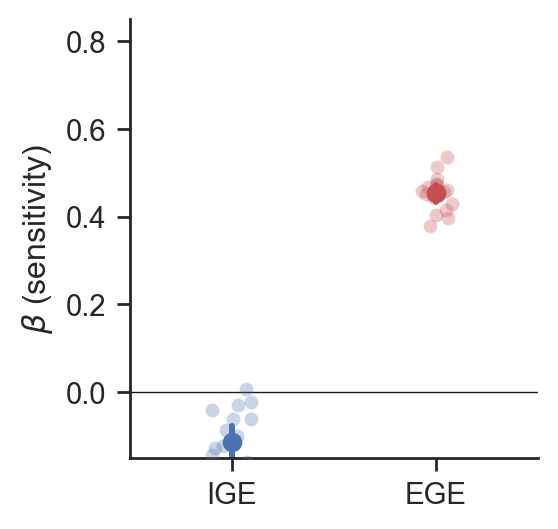

In [7]:
# Plot regression coefficients
n = len(beta_ege)
subj_num = np.linspace(1, len(beta_ege), len(beta_ege), n)
data = pd.DataFrame({
    "subject":subj_num, 
    "EGE": np.repeat("EGE", n),
    "IGE": np.repeat("IGE", n),
    "beta_ege":beta_ege * -1, 
    "beta_ige":beta_ige * -1
})

def plot_coeffs(ax, data, y1, y2):
    sns.pointplot(data=data, x="IGE", y=y1, ax=ax, c="b")
    sns.stripplot(data=data, x="IGE", y=y1, alpha=0.3, ax=ax, c="b")
    sns.pointplot(data=data, x="EGE", y=y2, ax=ax, c="r")
    sns.stripplot(data=data, x="EGE", y=y2, alpha=0.3, ax=ax, c="r")
    ax.axhline(linewidth=0.5, color="k")
    plt.tight_layout()
    return ax

def set_labels(fig, ax, title=None):
    ax.set(xlabel="", ylabel=r"$\beta$ (sensitivity)", title=title, ylim=(-0.15, 0.85))
    sns.despine()
    
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_theme(context="paper", font_scale=1.2)
    sns.set_style("ticks")

set_style()
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax = plot_coeffs(ax, data, data["beta_ige"], data["beta_ege"])

set_labels(fig, ax)
